In [1]:
import numpy as np
import matplotlib.pyplot as plt


def get_note_freq(p):
    """
    Return the frequency corresponding to a particular
    note number
    Parameters
    ----------
    p: int
        Note number, in halfsteps.  0 is a concert a
    """
    return 440*2**(p/12)
def load_tune(filename, tune_length):
    """
    Load in information about notes and their
    onset times from a text file
    Parameters
    ----------
    filename: string
        Path to file with the tune
    tune_length: float
        Length, in seconds, of the tune
    
    Returns
    -------
    ps: ndarray(N)
        A list of N note numbers
    times: ndarray(N)
        Duration of each note, in increments
        of sixteenth notes
    """
    tune = np.loadtxt(filename)
    ps = tune[:, 0]
    times = np.zeros(tune.shape[0])
    times[1::] = np.cumsum(tune[0:-1, 1])
    times = times*tune_length/np.sum(tune[:, 1])
    return ps, times




In [2]:
%load_ext autoreload
%autoreload 2
import IPython.display as ipd
from instruments import *
sr = 44100
note = -12
duration = 1
decay = 0.98
x = karplus_strong_note(sr, note, duration, decay)
ipd.Audio(x, rate=sr)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
def get_note_freq(p):
    """
    Return the frequency corresponding to a particular
    note number
    Parameters
    ----------
    p: int
        Note number, in halfsteps.  0 is a concert a
    """
    return 440*2**(p/12)
def karplus_strong_note(sr, note, duration, decay):
    """
    Parameters
    ----------
    sr: int
        Sample rate
    note: int
        Note number.  0 is 440hz concert A
    duration: float
        Seconds of audio
    decay: float 
        Decay amount (between 0 and 1)

    Returns
    -------
    ndarray(N): Audio samples for this note
    """
    N = int(duration*sr)
    y = np.zeros(N)
    f = 440*2**(note/12) #stolen from assignment 1, the eq is 440*2**(note/12)
    T = int(sr/f)#this should calculate the period in samples per f seconds
    # we want to initialize the first T samples as random noise and populate 0 through T with random values
    y[0:T] = np.random.rand(T) #generates T random noise samples
    #next we populate the y array
    for i in range(T, N):
        y[i] = decay*((y[i-T]+y[i-T+1])/2)
    return y


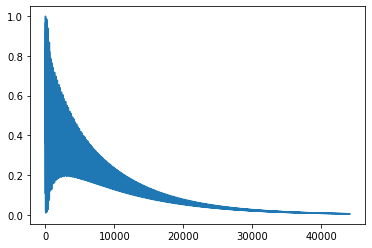

In [2]:
import IPython.display as ipd
from instruments import *
sr = 44100
note = -12
duration = 1
decay = 0.98
x = karplus_strong_note(sr, note, duration, decay)
plt.plot(x)
ipd.Audio(x, rate=sr)

In [5]:
def make_tune(filename, sixteenth_len, sr, note_fn):
    """
    Parameters
    ----------
    filename: string
        Path to file containing the tune.  Consists of
        rows of <note number> <note duration>, where
        the note number 0 is a 440hz concert A, and the
        note duration is in factors of 16th notes
    sixteenth_len: float
        Length of a sixteenth note, in seconds
    sr: int
        Sample rate
    note_fn: function (sr, note, duration) -> ndarray(M)
        A function that generates audio samples for a particular
        note at a given sample rate and duration
    
    Returns
    -------
    ndarray(N): Audio containing the tune
    """
    tune = np.loadtxt(filename)
    notes = tune[:, 0]
    durations = tune[:, 1]
    durations_sec = durations*sixteenth_len
    ret = []
    n = len(notes) #number of notes
    for i in range(n):
        x = note_fn(sr, notes[i], durations_sec[i])
        if np.isnan(notes[i]): #if the note is not a number, append 0 into y such that it has no value i.e is silent
            x = np.zeros(int(durations_sec[i]*sr))
            ret = np.concatenate((ret, x))
        else:
            ret = np.concatenate((ret, x))
    return ret 


In [6]:
%load_ext autoreload
%autoreload 2
import IPython.display as ipd
from instruments import *
sr = 44100
note_fn = lambda sr, note, duration: karplus_strong_note(sr, note, duration, 0.99)
y = make_tune("Tunes/missy.txt", 0.18, 44100, note_fn)
ipd.Audio(y, rate=sr)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
sr = 44100
note_fn = lambda sr, note, duration: karplus_strong_note(sr, note-12, duration, 0.92)
y = make_tune("Tunes/missy.txt", 0.18, 44100, note_fn)
ipd.Audio(y, rate=sr)

In [10]:
def exp_env(N, sr, lam = 3):
    """
    Make an exponential envelope
    Parameters
    ----------
    N: int
        Number of samples
    sr: int
        Sample rate
    lam: float
        Exponential decay rate: e^{-lam*t}

    Returns
    -------
    ndarray(N): Envelope samples
    """
    return np.exp(-lam*np.arange(N)/sr)

In [11]:
def fm_plucked_string_note(sr, note, duration, lam = 3):
    """
    Make a plucked string of a particular length
    using FM synthesis
    Parameters
    ----------
    sr: int
        Sample rate
    note: int
        Note number.  0 is 440hz concert A
    duration: float
        Seconds of audio
    lam: float
        The decay rate of the note
    
    Returns
    -------
    ndarray(N): Audio samples for this note
    """
    envelope = lambda N, sr: exp_env(N, sr, lam)
    return fm_synth_note(sr, note, duration, \
                ratio = 1, I = 8, envelope = envelope,
                amplitude = envelope)

In [118]:
def fm_synth_note(sr, note, duration, ratio = 2, I = 2, 
                  envelope = lambda N, sr: np.ones(N),
                  amplitude = lambda N, sr: np.ones(N)):
    """
    Parameters
    ----------
    sr: int
        Sample rate
    note: int
        Note number.  0 is 440hz concert A
    duration: float
        Seconds of audio
    ratio: float
        Ratio of modulation frequency to carrier frequency
    I: float
        Modulation index (ratio of peak frequency deviation to
        modulation frequency)
    envelope: function (N, sr) -> ndarray(N)
        A function for generating an ADSR profile
    amplitude: function (N, sr) -> ndarray(N)
        A function for generating a time-varying amplitude

    Returns
    -------
    ndarray(N): Audio samples for this note
    """
    N = int(duration*sr)
    y = np.zeros(N)
    t = np.arange(N)/sr
    fc = 440*2**(note/12)
    fm = fc*ratio
    env= I*envelope(N, sr)  #numpy array that is the full time variant
    amp = amplitude(N, sr)
    print("env: ", len(env))
    print("amp: ", len(amp))
    print("t: ", len(t))
    #y(t) = A(t)cos(2*pi*fc*t+I(t)sin(2*pi*fm*t))
    y = amp*np.cos(2*np.pi*fc*t + env*np.sin(2*np.pi*fm*t))
    return y


In [384]:
sr = 44100
note_fn = lambda sr, note, duration: fm_plucked_string_note(sr, note, duration, 8)
y = make_tune("Tunes/dangerzone.txt", 0.1, 44100, note_fn)
ipd.Audio(y, rate=sr)

env:  8820
amp:  8820
t:  8820
env:  8820
amp:  8820
t:  8820
env:  8820
amp:  8820
t:  8820
env:  17640
amp:  17640
t:  17640
env:  17640
amp:  17640
t:  17640
env:  26460
amp:  26460
t:  26460
env:  8820
amp:  8820
t:  8820
env:  17640
amp:  17640
t:  17640
env:  26460
amp:  26460
t:  26460
env:  8820
amp:  8820
t:  8820
env:  8820
amp:  8820
t:  8820
env:  8820
amp:  8820
t:  8820
env:  17640
amp:  17640
t:  17640
env:  17640
amp:  17640
t:  17640
env:  26460
amp:  26460
t:  26460
env:  8820
amp:  8820
t:  8820
env:  17640
amp:  17640
t:  17640
env:  26460
amp:  26460
t:  26460
env:  8820
amp:  8820
t:  8820
env:  17640
amp:  17640
t:  17640
env:  17640
amp:  17640
t:  17640
env:  17640
amp:  17640
t:  17640
env:  70560
amp:  70560
t:  70560
env:  8820
amp:  8820
t:  8820
env:  8820
amp:  8820
t:  8820
env:  8820
amp:  8820
t:  8820
env:  17640
amp:  17640
t:  17640
env:  17640
amp:  17640
t:  17640
env:  26460
amp:  26460
t:  26460


In [132]:
def brass_env(N, sr):
    """
    Make the brass ADSR envelope from Chowning's paper
    Parameters
    ----------
    N: int
        Number of samples
    sr: int
        Sample rate
    
    Returns
    -------
    ndarray(N): Envelope samples
    """
    #N = dur*sr
    #dur = N/sr
    y = np.zeros(N)
    dur = N/sr
    if dur <= 0.3:
        atk = np.linspace(0, 1, int(sr*0.05))
        dec = np.linspace(1, 0.75, (int(sr*0.2)-int(sr*0.05)))
        rel = np.linspace(0.75, 0, (int(sr*1) - int(sr*0.95)))
        y = np.concatenate((atk, dec, rel))
    else:
        atk = np.linspace(0, 1, int(sr*0.1))
        dec = np.linspace(1, 0.75, int(sr*0.1))
        sus = np.linspace(0.75, 0.7, (int(sr*0.9)-int(sr*0.2)))
        rel = np.linspace(0.7, 0, int(sr*0.1))
        y = np.concatenate((atk, dec, sus, rel))
    return y

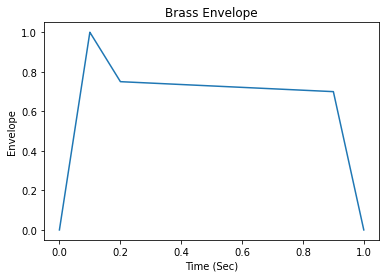

In [133]:
sr = 44100
N = int(sr)
t = np.arange(N)/sr
env = brass_env(N, sr)
plt.plot(t, env)
plt.xlabel("Time (Sec)")
plt.ylabel("Envelope")
plt.title("Brass Envelope")
plt.savefig("Brass.svg", bbox_inches='tight')

In [138]:
def fm_brass_note(sr, note, duration):
    """
    Make a brass note of a particular length
    Parameters
    ----------
    sr: int
        Sample rate
    note: int
        Note number.  0 is 440hz concert A
    duration: float
        Seconds of audio
    
    Return
    ------
    ndarray(N): Audio samples for this note
    """
    envelope = lambda N, sr: brass_env(N, sr)
    return fm_synth_note(sr, note, duration, \
                ratio = 1, I = 10, envelope = envelope,
                amplitude = envelope)

In [139]:
sr = 44100
y = make_tune("Tunes/usher.txt", 0.5, 44100, fm_brass_note)
ipd.Audio(y, rate=sr)

env:  44100
amp:  44100
t:  22050


ValueError: operands could not be broadcast together with shapes (44100,) (22050,) 

In [385]:
def fm_bell_note(sr, note, duration):
    """
    Make a bell note of a particular length
    Parameters
    ----------
    sr: int
        Sample rate
    note: int
        Note number.  0 is 440hz concert A
    duration: float
        Seconds of audio
    
    Returns
    -------
    ndarray(N): Audio samples for this note
    """
    envelope = lambda N, sr: exp_env(N, sr, 0.8)
    return fm_synth_note(sr, note, duration, \
                ratio = 1.4, I = 2, envelope = envelope,
                amplitude = envelope)

In [386]:
sr = 44100
y = make_tune("Tunes/westminster.txt", 0.4, 44100, fm_bell_note)
ipd.Audio(y, rate=sr)

env:  35280
amp:  35280
t:  35280
env:  35280
amp:  35280
t:  35280
env:  35280
amp:  35280
t:  35280
env:  70560
amp:  70560
t:  70560
env:  35280
amp:  35280
t:  35280
env:  35280
amp:  35280
t:  35280
env:  35280
amp:  35280
t:  35280
env:  70560
amp:  70560
t:  70560
env:  35280
amp:  35280
t:  35280
env:  35280
amp:  35280
t:  35280
env:  35280
amp:  35280
t:  35280
env:  70560
amp:  70560
t:  70560
env:  35280
amp:  35280
t:  35280
env:  35280
amp:  35280
t:  35280
env:  35280
amp:  35280
t:  35280
env:  70560
amp:  70560
t:  70560
env:  70560
amp:  70560
t:  70560
env:  70560
amp:  70560
t:  70560
env:  70560
amp:  70560
t:  70560
env:  70560
amp:  70560
t:  70560
env:  564480
amp:  564480
t:  564480


In [494]:
def drum_like_env(N, sr):
    """
    Make a drum-like envelope, according to Chowning's paper
    Parameters
    ----------
    N: int
        Number of samples
    sr: int
        Sample rate

    Returns
    -------
    ndarray(N): Envelope samples
    """
    t = np.arange(N)/sr
    y = np.zeros(N)
    y = (((t**2)*exp_env(N, sr, 30)*275)+0.225)
    return y

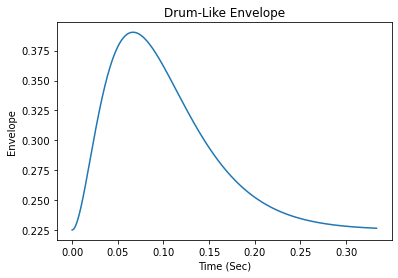

In [495]:
sr = 44100
N = int(sr/3)
t = np.arange(N)/sr
env = drum_like_env(N, sr)
plt.plot(t, env)
plt.xlabel("Time (Sec)")
plt.ylabel("Envelope")
plt.title("Drum-Like Envelope")
plt.savefig("DrumLike.svg", bbox_inches='tight')

In [496]:
def fm_drum_sound(sr, note, duration, fixed_note = -14):
    """
    Make what Chowning calls a "drum-like sound"
    Parameters
    ----------
    sr: int
        Sample rate
    note: int
        Note number (which is ignored)
    duration: float
        Seconds of audio
    fixed_note: int
        Note number of the fixed note for this drum
    
    Returns
    ------
    ndarray(N): Audio samples for this drum hit
    """
    envelope = lambda N, sr: drum_like_env(N, sr)
    return fm_synth_note(sr, note, duration, \
                ratio = 1.4, I = 2, envelope = envelope,
                amplitude = envelope)

In [497]:
sr = 44100
y = make_tune("Tunes/3on4.txt", 0.2, 44100, fm_drum_sound)
ipd.Audio(y, rate=sr)

env:  26460
amp:  26460
t:  26460
env:  8820
amp:  8820
t:  8820
env:  17640
amp:  17640
t:  17640
env:  17640
amp:  17640
t:  17640
env:  8820
amp:  8820
t:  8820
env:  26460
amp:  26460
t:  26460
env:  26460
amp:  26460
t:  26460
env:  8820
amp:  8820
t:  8820
env:  17640
amp:  17640
t:  17640
env:  17640
amp:  17640
t:  17640
env:  8820
amp:  8820
t:  8820
env:  26460
amp:  26460
t:  26460


In [484]:
def wood_drum_env(N, sr):
    """
    Make the wood-drum envelope from Chowning's paper
    Parameters
    ----------
    N: int
        Number of samples
    sr: int
        Sample rate

    Returns
    -------
    ndarray(N): Envelope samples
    """
    y = np.zeros(N)
    t = np.arange(N)/sr
    atk = np.linspace(1, 0, int(0.025*sr))
    rest = np.linspace(0, 0, (int(sr) - int(0.025*sr)))
    y = np.concatenate(atk, rest)
    return y

In [485]:
sr = 44100
N = int(sr/6)
t = np.arange(N)/sr
env = wood_drum_env(N, sr)
plt.plot(t, env)
plt.xlabel("Time (Sec)")
plt.ylabel("Envelope")
plt.title("Wood Drum Envelope")
plt.savefig("WoodDrum.svg", bbox_inches='tight')


TypeError: only integer scalar arrays can be converted to a scalar index

In [508]:
def fm_dirty_bass_note(sr, note, duration):
    """
    Make a "dirty bass" note, based on 
    https://www.attackmagazine.com/technique/tutorials/dirty-fm-bass/
    Parameters
    ----------
    sr: int
        Sample rate
    note: int
        Note number (which is ignored)
    duration: float
        Seconds of audio
    
    Returns
    -------
    ndarray(N): Audio samples for this drum hit
    """
    
    envelope = lambda N, sr: dirty_bass_env(N, sr)
    return fm_synth_note(sr, note, duration, \
                ratio = 1, I = 18, envelope = envelope,
                amplitude = envelope) 

In [518]:
def dirty_bass_env(N, sr):
    """
    Make the "dirty bass" envelope from Attack Magazine
    https://www.attackmagazine.com/technique/tutorials/dirty-fm-bass/
    Parameters
    ----------
    N: int
        Number of samples
    sr: int
        Sample rate
    
    Returns
    -------
    ndarray(N): Envelope samples
    """
    env = exp_env(N, sr)
    for i in range(0, int(N/2)):
        t = i/N
        env[i] = i-t
        env[int(N/2)+i] = 1 - (i-t)
    return env

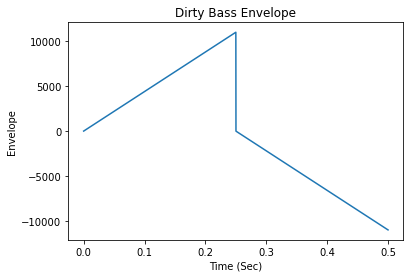

In [519]:
sr = 44100
N = int(sr/2)
t = np.arange(N)/sr
env = dirty_bass_env(N, sr)
plt.plot(t, env)
plt.xlabel("Time (Sec)")
plt.ylabel("Envelope")
plt.title("Dirty Bass Envelope")
plt.savefig("DirtyBass.svg", bbox_inches='tight')

In [511]:
sr = 44100
y = make_tune("Tunes/dirtybass.txt", 0.25, 44100, fm_dirty_bass_note)
ipd.Audio(y, rate=sr)

env:  22050
amp:  22050
t:  22050
env:  22050
amp:  22050
t:  22050
env:  22050
amp:  22050
t:  22050
env:  22050
amp:  22050
t:  22050
env:  22050
amp:  22050
t:  22050
env:  22050
amp:  22050
t:  22050
env:  22050
amp:  22050
t:  22050
env:  22050
amp:  22050
t:  22050
env:  22050
amp:  22050
t:  22050
env:  22050
amp:  22050
t:  22050
env:  22050
amp:  22050
t:  22050
env:  22050
amp:  22050
t:  22050
env:  22050
amp:  22050
t:  22050
env:  22050
amp:  22050
t:  22050
env:  22050
amp:  22050
t:  22050
env:  22050
amp:  22050
t:  22050
